In [1]:
import numpy
import pandas
import tensorflow
import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import pathlib

%matplotlib inline

In [2]:
# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth'] # 'sepallength', 'sepalwidth', 'petallength', 'petalwidth'
class_col = 'flower'
my_class = 'Iris-versicolor' # 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'

# TRAINING PARAMETERS
max_hidden_neurons = 5
hidden_neuron_activation = 'tanh' # 'tanh', 'relu', 'sigmoid'
my_metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
my_patience = 300
max_epoch = 10*my_patience
min_improvement = 0.01
min_neuron_gain = 0.01
min_median_gain = 0.01
rmsprop_lr = 0.001
adam_initial_lr = 0.01
adam_decay_steps = max_epoch
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True

# CONTROL RANDOMNESS
random_seed = 33
n_k_folds = 5

In [3]:
# SET THE RANDOM SEED
# numpy.random.seed(random_seed)
# tensorflow.random.set_seed(random_seed)
keras.utils.set_random_seed(random_seed)

In [4]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent.parent
path_to_iris = data_folder / 'datasets' / 'iris.data'
my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv(path_to_iris, sep=',', decimal='.')
iris = iris[my_vars_w_class]
iris

,petallength,petalwidth,flower
0,1.4,0.2,Iris-setosa
1,1.4,0.2,Iris-setosa
2,1.3,0.2,Iris-setosa
3,1.5,0.2,Iris-setosa
4,1.4,0.2,Iris-setosa
...,...,...,...
145,5.2,2.3,Iris-virginica
146,5.0,1.9,Iris-virginica
147,5.2,2.0,Iris-virginica
148,5.4,2.3,Iris-virginica


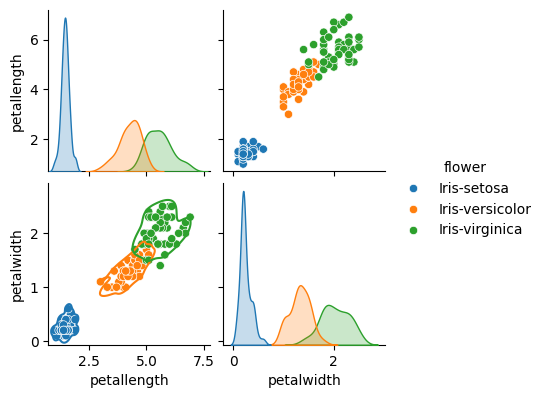

In [5]:
# SCATTER PLOT
_ = g = seaborn.pairplot(iris, hue='flower', height=2, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [6]:
# ROBUST TRAINING PROCEDURE

# OPTIMIZERS TO COMPARE
adam_lr_schedule = keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                               adam_decay_steps,
                                                               adam_lr_decay)

# my_optimizers = {'adam': keras.optimizers.Adam(learning_rate=adam_lr_schedule),
#                  'rmsprop': keras.optimizers.RMSprop(learning_rate=rmsprop_lr)}

my_optimizers = ['adam', 'rmsprop']

# PREPARE DATA
X = iris[my_vars].to_numpy()
if my_class not in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    print(f'Classe {my_class} não encontrada! Digite uma das seguintes classes: Iris-setosa, Iris-versicolor, Iris-virginica')
else:
    Y = (iris['flower'] == my_class).astype(float).to_numpy()[:, numpy.newaxis] # 0 / 1

    # NORMALIZE VARIABLES
    X_scaler = StandardScaler()
    X_scaler = X_scaler.fit(X)
    X_scaled = X_scaler.transform(X)

    # GET STRATIFIED FOLDS
    sk_folds = StratifiedKFold(n_splits=n_k_folds)
    sk_folds.get_n_splits(X_scaled, Y)

    # TRAINING LOOP
    # FOR EACH OPTIMIZER
    best_net_name = None
    best_net = None
    best_metric = 0.0
    best_metric_val = 0.0
    metric_lower_bound = 0.0
    metric_median = 0.0
    result_list = []
    print('TRAINING PROCEDURE STARTED...\n')
    for n_neuron in numpy.arange(1, max_hidden_neurons+1):
        # FOR 1 TO MAX_HIDDEN_NEURONS
        ix_fold = 1
        for train_index, test_index in sk_folds.split(X_scaled, Y):
            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            
            for optimizer_name in my_optimizers:
                # DECLARE NET
                inputs = keras.Input(shape=(len(my_vars), ))
                hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
                outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
                model_name = '{}-N{}F{}_{}'.format(optimizer_name.upper(), n_neuron, ix_fold, my_class)
                my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
                val_metric_name = 'val_{}'.format(my_metric)

                if optimizer_name == 'adam':
                    adam_lr_schedule = keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                                                   adam_decay_steps,
                                                                                   adam_lr_decay)
                    optimizer = keras.optimizers.Adam(learning_rate=adam_lr_schedule)
                elif optimizer_name == 'rmsprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=rmsprop_lr)

                my_net.compile(optimizer=optimizer, loss='mse', metrics=[my_metric])
                es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)
                # es_val_metric = keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max', patience=n_k_folds*my_patience, min_delta=min_improvement, restore_best_weights=True)
                
                # FIT W CLASS WEIGHTS
                my_class_weight = Y_train.shape[0]/Y_train.sum()
                other_class_weight = Y_train.shape[0]/(Y_train==0).sum()
                class_weights = {0: other_class_weight, 1: my_class_weight}
                history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric], class_weight=class_weights)

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[my_metric][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                    best_net_name = model_name
                    best_optimizer_name = optimizer_name
                    best_optimizer = optimizer
                    best_net = my_net
                    best_neurons = n_neuron
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'
                    is_best = True

                result_dict = {'model_name': model_name,
                               'optimizer_name' : optimizer_name,
                               'optimizer': optimizer,
                               'neurons': n_neuron,
                               'fold': ix_fold,
                               'loss': model_loss,
                               'val_loss': model_val_loss,
                               my_metric: metric_val,
                               val_metric_name: val_metric_val,
                               'epochs': n_epochs,
                               'is_best': is_best,
                               'net': my_net,
                               'history': history}
                result_list.append(result_dict)

                print('{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% {}'.format(model_name, n_epochs, model_loss, model_val_loss, my_metric,
                                                                                                    100.0*metric_val, val_metric_name, 100.0*val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            print('')
            ix_fold += 1
            
        # TEST IF MORE NEURONS ARE NECESSARY
        dont_need_extra_neurons = False
        if n_neuron > 1:
            
            # INCREASING NEURONS DIDNT ACHIEVE BEST NET
            if best_neurons < n_neuron:
                dont_need_extra_neurons = True
                print('NETs w {} neurons didnt improve {}!'.format(n_neuron, my_metric))
                break

        # GET LOWER BOUND OF WINNING ALGORITHM
        df_results = pandas.DataFrame(result_list)
        lower_bound_est = df_results[(df_results.optimizer_name == best_optimizer_name) & (df_results.neurons == n_neuron)][val_metric_name].min()
        median_est = df_results[(df_results.optimizer_name == best_optimizer_name) & (df_results.neurons == n_neuron)][val_metric_name].median()

        # TEST IF LOWER BOUND IMPROVED AND MEDIAN IMPROVED
        fold_improve = False
        if n_neuron > 1:
            neuron_gain = 0.0
            if lower_bound_est > metric_lower_bound or median_est > metric_median:
                if metric_lower_bound > 0.0 and metric_median > 0.0:
                    neuron_gain = lower_bound_est/metric_lower_bound - 1.0
                    median_gain = median_est/metric_median - 1.0
                    if neuron_gain <= min_neuron_gain and median_gain <= min_median_gain:
                        print('NETs w {} neurons didnt improve min {} {:.1f} neuron gain {:.1f} / min {:.1f} or median gain {:.1f} / min {:.1f}!'.format(n_neuron, val_metric_name, 100.0*lower_bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain, 100.0*median_gain, 100.0*min_median_gain))
                        fold_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}% | Median Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}%'.format(n_neuron, 100.0*metric_lower_bound, 100.0*lower_bound_est ,100.0*neuron_gain, n_neuron, 100.0*metric_median, 100.0*median_est, 100.0*median_gain))
                else:
                    print('NET Neural Gain From 0.0 >> {:.1f}% and Median Gain From 0.0 >> {:.1f}%'.format(100.0*lower_bound_est, 100.0*median_est))
            else:
                print('No Lower Bound Gain on {} neurons for {}: {:.1f} >> {:.1f} or no Median Gain on {} neurons for {}: {:.1f} >> {:.1f}'.format(n_neuron, best_optimizer_name, 100.0*metric_lower_bound, 100.0*lower_bound_est, n_neuron, best_optimizer_name, 100.0*metric_median, 100.0*median_est))
                fold_improve = False
                break
        else:
            print('NET Lower Bound Estimation for {} neuron: {:.1f}% | Median {:.1f}%'.format(n_neuron, 100.0*lower_bound_est, 100.0*median_est))
        
        metric_lower_bound = lower_bound_est
        metric_median = median_est
        print('')

        if maximized_metrics or dont_need_extra_neurons:
            break

TRAINING PROCEDURE STARTED...

ADAM-N1F1_Iris-versicolor > epochs: 455 loss: 0.49 val_loss: 0.34 Accuracy: 66% val_Accuracy: 20% **Best NET!**
RMSPROP-N1F1_Iris-versicolor > epochs: 301 loss: 0.49 val_loss: 0.18 Accuracy: 52% val_Accuracy: 97% 

ADAM-N1F2_Iris-versicolor > epochs: 455 loss: 0.50 val_loss: 0.26 Accuracy: 60% val_Accuracy: 27% 
RMSPROP-N1F2_Iris-versicolor > epochs: 301 loss: 0.46 val_loss: 0.14 Accuracy: 55% val_Accuracy: 97% 

ADAM-N1F3_Iris-versicolor > epochs: 313 loss: 0.45 val_loss: 0.23 Accuracy: 64% val_Accuracy: 67% 
RMSPROP-N1F3_Iris-versicolor > epochs: 521 loss: 0.50 val_loss: 0.25 Accuracy: 55% val_Accuracy: 53% 

ADAM-N1F4_Iris-versicolor > epochs: 301 loss: 0.40 val_loss: 0.40 Accuracy: 70% val_Accuracy: 30% **Best NET!**
RMSPROP-N1F4_Iris-versicolor > epochs: 339 loss: 0.56 val_loss: 0.19 Accuracy: 42% val_Accuracy: 83% 

ADAM-N1F5_Iris-versicolor > epochs: 301 loss: 0.39 val_loss: 0.42 Accuracy: 70% val_Accuracy: 30% 
RMSPROP-N1F5_Iris-versicolor > epoch

In [7]:
df_results.sort_values(by=[f'val_{my_metric}', my_metric, 'neurons'], ascending=[False, False, True])

,model_name,optimizer_name,optimizer,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,is_best,net,history
11,RMSPROP-N2F1_Iris-versicolor,rmsprop,<keras.src.optimizers.rmsprop.RMSprop object a...,2,1,0.152897,0.056330,0.958333,1.000000,1185,False,"<Functional name=RMSPROP-N2F1_Iris-versicolor,...",<keras.src.callbacks.history.History object at...
10,ADAM-N2F1_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,1,0.173795,0.066286,0.950000,1.000000,1194,True,"<Functional name=ADAM-N2F1_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
13,RMSPROP-N2F2_Iris-versicolor,rmsprop,<keras.src.optimizers.rmsprop.RMSprop object a...,2,2,0.336076,0.172217,0.950000,1.000000,875,False,"<Functional name=RMSPROP-N2F2_Iris-versicolor,...",<keras.src.callbacks.history.History object at...
3,RMSPROP-N1F2_Iris-versicolor,rmsprop,<keras.src.optimizers.rmsprop.RMSprop object a...,1,2,0.464287,0.137279,0.550000,0.966667,301,False,"<Functional name=RMSPROP-N1F2_Iris-versicolor,...",<keras.src.callbacks.history.History object at...
1,RMSPROP-N1F1_Iris-versicolor,rmsprop,<keras.src.optimizers.rmsprop.RMSprop object a...,1,1,0.490582,0.182131,0.525000,0.966667,301,False,"<Functional name=RMSPROP-N1F1_Iris-versicolor,...",<keras.src.callbacks.history.History object at...
14,ADAM-N2F3_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,3,0.166648,0.097328,0.966667,0.900000,937,False,"<Functional name=ADAM-N2F3_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
12,ADAM-N2F2_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,2,0.501319,0.155357,0.533333,0.866667,301,False,"<Functional name=ADAM-N2F2_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
7,RMSPROP-N1F4_Iris-versicolor,rmsprop,<keras.src.optimizers.rmsprop.RMSprop object a...,1,4,0.557904,0.187037,0.416667,0.833333,339,False,"<Functional name=RMSPROP-N1F4_Iris-versicolor,...",<keras.src.callbacks.history.History object at...
15,RMSPROP-N2F3_Iris-versicolor,rmsprop,<keras.src.optimizers.rmsprop.RMSprop object a...,2,3,0.309270,0.172676,0.733333,0.666667,456,False,"<Functional name=RMSPROP-N2F3_Iris-versicolor,...",<keras.src.callbacks.history.History object at...
4,ADAM-N1F3_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,1,3,0.449711,0.227958,0.641667,0.666667,313,False,"<Functional name=ADAM-N1F3_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...


In [8]:
# AGGREGATE BY NEURONS AND OPTIMIZER
df_results_agg = df_results.groupby(['neurons', 'optimizer_name']).agg({f'val_{my_metric}': ['mean', 'std', 'min', 'max']}).reset_index()
df_results_agg.columns = ['neurons', 'optimizer_name', 'mean', 'std', 'min', 'max']
df_results_agg = df_results_agg.sort_values(by=['min', 'neurons'], ascending=[False, True])
df_results_agg

,neurons,optimizer_name,mean,std,min,max
2,2,adam,0.713333,0.298701,0.300000,1.000000
1,1,rmsprop,0.713333,0.306050,0.266667,0.966667
3,2,rmsprop,0.653333,0.350872,0.266667,1.000000
0,1,adam,0.346667,0.183485,0.200000,0.666667


In [9]:
best_hyperconfig = df_results_agg.iloc[0]
best_neurons = int(best_hyperconfig['neurons'])
best_optimizer_name = best_hyperconfig['optimizer_name']
best_hyperconfig

neurons                  2
optimizer_name        adam
mean              0.713333
std               0.298701
min                    0.3
max                    1.0
Name: 2, dtype: object

In [10]:
best_rows = df_results[(df_results.neurons == best_neurons) & (df_results.optimizer_name == best_optimizer_name)]
best_net_name = best_rows['model_name'].values[0]
best_optimizer = best_rows['optimizer'].values[0]
best_net = best_rows['net'].values[0]
best_neurons = best_rows['neurons'].values[0]
best_metric = best_rows[my_metric].values[0]
best_metric_val = best_rows[val_metric_name].values[0]
best_history = best_rows['history'].values[0]

best_rows


,model_name,optimizer_name,optimizer,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,is_best,net,history
10,ADAM-N2F1_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,1,0.173795,0.066286,0.950000,1.000000,1194,True,"<Functional name=ADAM-N2F1_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
12,ADAM-N2F2_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,2,0.501319,0.155357,0.533333,0.866667,301,False,"<Functional name=ADAM-N2F2_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
14,ADAM-N2F3_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,3,0.166648,0.097328,0.966667,0.900000,937,False,"<Functional name=ADAM-N2F3_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
16,ADAM-N2F4_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,4,0.375273,0.313949,0.708333,0.300000,301,False,"<Functional name=ADAM-N2F4_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...
18,ADAM-N2F5_Iris-versicolor,adam,<keras.src.optimizers.adam.Adam object at 0x00...,2,5,0.393685,0.273478,0.766667,0.500000,301,False,"<Functional name=ADAM-N2F5_Iris-versicolor, bu...",<keras.src.callbacks.history.History object at...


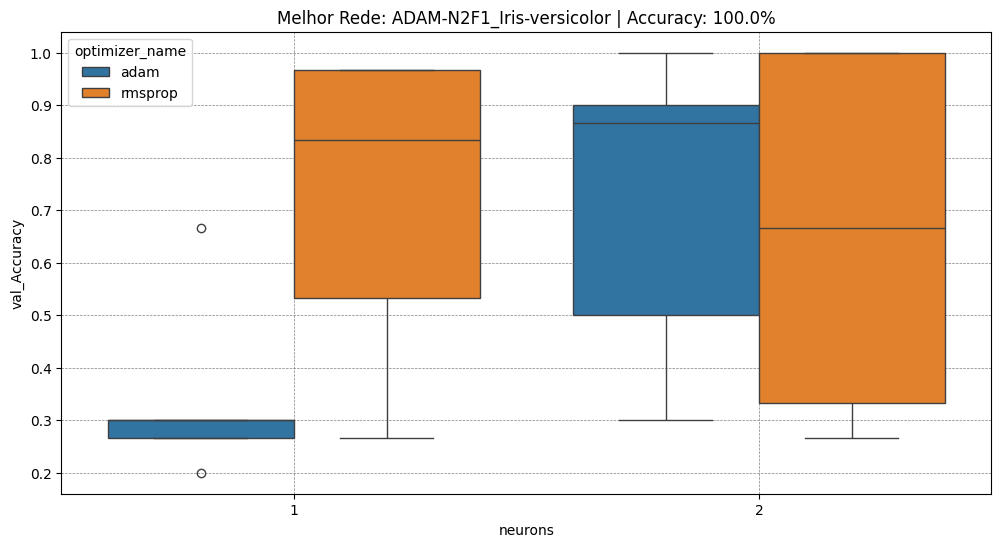

In [11]:
# DRAW A BOXPLOT OF THE RESULTS, GROUPING BY NEURONS AND OPTIMIZER
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(data=df_results, x='neurons', y=f'val_{my_metric}', hue='optimizer_name', ax=ax)
_ = ax.set_title(f'Melhor Rede: {best_net_name} | {my_metric}: {100.0*best_metric_val:.1f}%')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

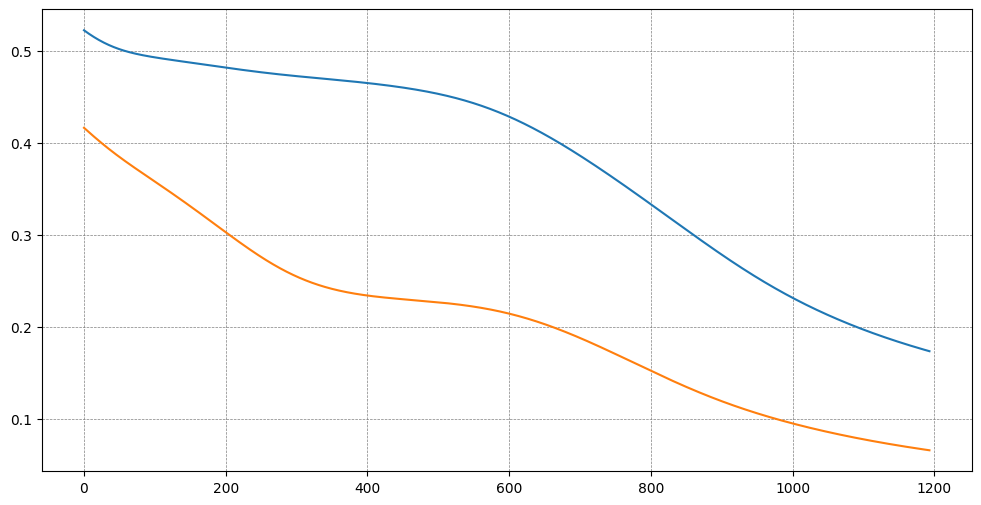

In [12]:
# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(best_history.history['loss'], label='loss')
_ = ax.plot(best_history.history['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

In [13]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
class_threshold = 0.5
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1

# X0 W JITTER
x0_grid = numpy.linspace(0, rect_expansion*(X[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = X_scaler.transform(X_g)
Y_g = best_net.predict(X_g_scaled, verbose=0)
Y_est = (best_net.predict(X_scaled, verbose=0) > class_threshold).astype(int)
t_error, t_statistic = best_net.evaluate(X_scaled, Y, verbose=0)

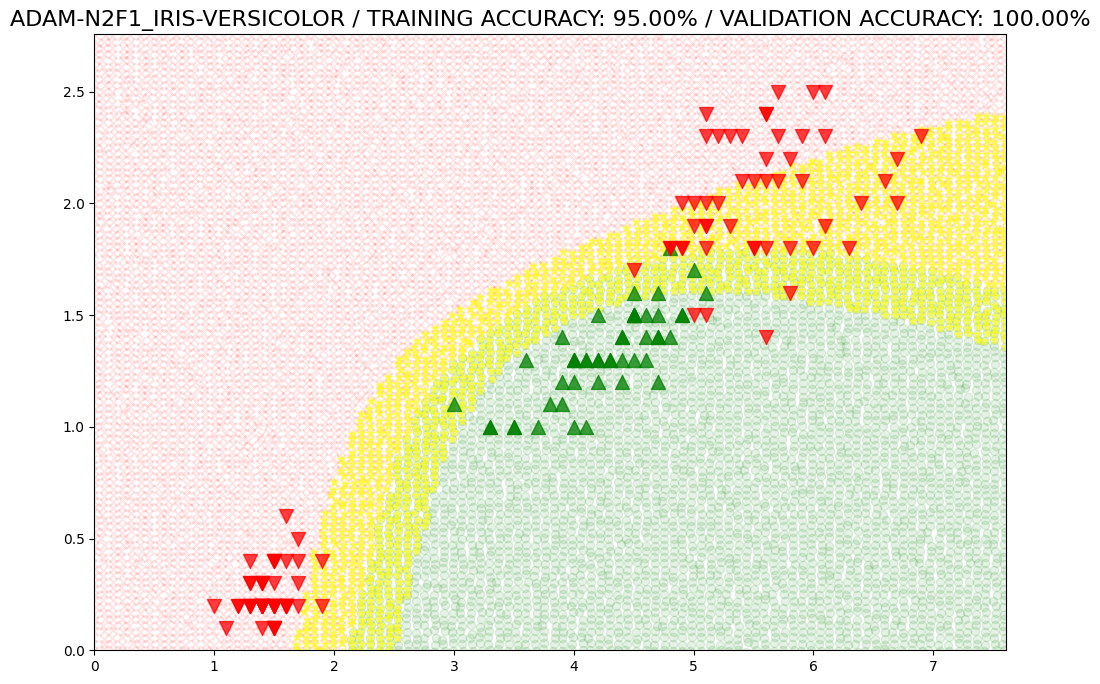

In [14]:
# CLASSIFICATION FIGURE
height = 8
fig = pyplot.figure(figsize=(height/0.68, height))
ax = fig.add_subplot(111)
# PLOT CLASS REGION
ix_class_region = Y_g.reshape(-1) > class_threshold
ix_class_points = Y.reshape(-1) == 1
ix_surface = (Y_g.reshape(-1) >= class_threshold - little_delta) &  (Y_g.reshape(-1) <= class_threshold + little_delta)
_ = ax.scatter(X_g[ix_class_region, 0], X_g[ix_class_region, 1], marker='o', color='green', alpha=0.1)
_ = ax.scatter(X_g[~ix_class_region, 0], X_g[~ix_class_region, 1], marker='x', color='red', alpha=0.1)
_ = ax.scatter(X_g[ix_surface, 0], X_g[ix_surface, 1], marker='*', color='yellow', alpha=0.5)
_ = ax.scatter(X[ix_class_points, 0], X[ix_class_points, 1], marker='^', color='green', alpha=0.75, s=100)
_ = ax.scatter(X[~ix_class_points, 0], X[~ix_class_points, 1], marker='v', color='red', alpha=0.75, s=100)
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title('{} / training {}: {:.2f}% / validation {}: {:.2f}%'.format(best_net_name, my_metric, 100.0*best_metric, my_metric,100.0*best_metric_val).upper(), size=16)